# GRU

The key distinction between vanilla RNNs and GRUs is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed. We discuss this in detail below.

In [1]:
%%capture
import torch
from torch import nn
from ipynb.fs.full.text_models import load_data_time_machine

from utils import train, RNNModelScratch, try_gpu, RNNModel

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

The next step is to initialize the model parameters. We draw the weights from a Gaussian distribution with standard deviation to be 0.01 and set the bias to 0 (random initialisation). The hyperparameter `num_hiddens` defines the number of hidden units. We instantiate all weights and biases relating to the update gate, the reset gate, the candidate hidden state, and the output layer.

In [2]:
def get_params(vocab_size, num_hiddens, device):
    """initialises the model parameters

    Args:
        vocab_size (_type_): _description_
        num_hiddens (int): number of hidden units
        device (_type_): _description_

    Returns:
        _type_: _description_
    """
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    # Helper functions to generate model weights, hidden state weights and biases
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

Now we will define the hidden state initialization function init_gru_state. Just like the init_rnn_state function defined in Section 8.5, this function returns a tensor with a shape (batch size, number of hidden units) whose values are all zeros.

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

Now we are ready to define the GRU model. Its structure is the same as that of the basic RNN cell, except that the update equations are more complex.

In [4]:
def gru(inputs, state, params):
    """ Gated Recurrent Unit Model- defines one chunk of a gru pass

    Args:
        inputs (_type_): _description_
        state (_type_): _description_
        params (_type_): _description_

    Returns:
        _type_: _description_
    """
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 76755.1 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


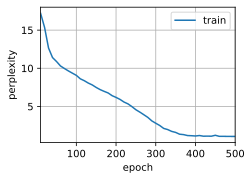

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
train(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 72205.0 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


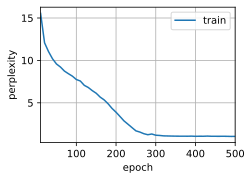

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

## Summary
* Gated RNNs can better capture dependencies for sequences with large time step distances.
* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.
* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.

### Hyperparameter Tuning Exercise
Adjusting the learning rate
* We see that a slower learning rate requires more epochs to go to lower perplexity
* The training time, for the same number of epochs, is the same
* The output does not make sense, as it is has not learnt yet
* For a large learning rate, the model does not converge and the perplexity is extremely large, the output does not make sense


perplexity 8.7, 79533.6 tokens/sec on cpu
time traveller and the the the the the the the the the the the t
traveller and the the the the the the the the the the the t


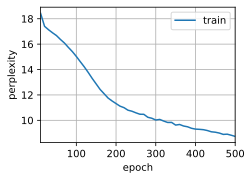

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, 0.1, num_epochs, device)

perplexity 1.0, 67055.8 tokens/sec on cpu
time travellerit would be remarkably convenient for the historia
traveller with a slight accession ofcheerfulness really thi


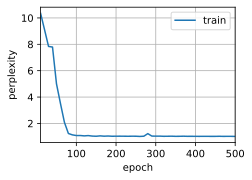

In [9]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, 5, num_epochs, device)

perplexity 383027554.5, 74985.9 tokens/sec on cpu
time travellermend dsssssmendssssmed mend med med med med med me
travellermend mes mest mend med med med med med med med med


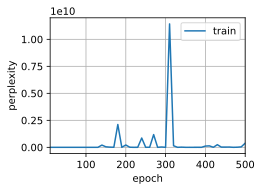

In [10]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, 10, num_epochs, device)

Hidden states

perplexity 1.0, 21360.5 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


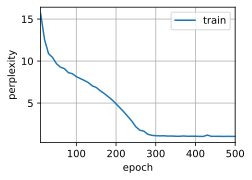

In [12]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens*2)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

perplexity 3.9, 343139.3 tokens/sec on cpu
time travellere and the time travel indifferently in time the ti
traveller and the medical man a sometht a move and the time


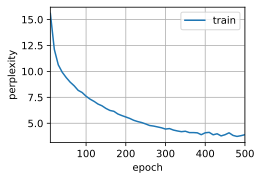

In [14]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, 32)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.7, 245964.8 tokens/sec on cpu
time traveller after threed dimensions bettion of as hat see peo
travelleryou can shave whong so move about in time and the 


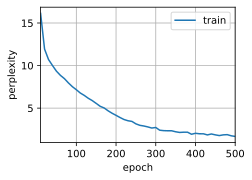

In [15]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, 64)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.2, 148334.4 tokens/sec on cpu
time travelleryou can show blags thepestrans of stactert is his 
traveller peomet you instancedisttbatini for which we can f


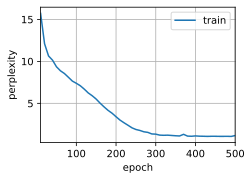

In [16]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, 128)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

Batch size: a small batch size means that there will be more updates in one epoch, so the runtime will increase and the perplexity is lower.

perplexity 1.6, 86786.3 tokens/sec on cpu
time traveller said filby whay the sarter absons thing to you ta
traveller smiled areverenten this that space as our mathema


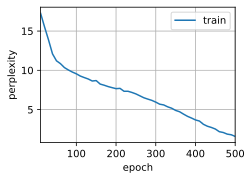

In [18]:
train_iter, vocab = load_data_time_machine(64, num_steps)
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.0, 47522.7 tokens/sec on cpu
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


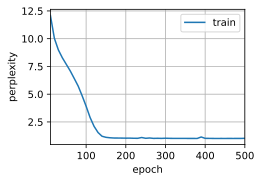

In [19]:
train_iter, vocab = load_data_time_machine(16, num_steps)
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, train_iter, vocab, lr, num_epochs, device)

## Exercises
1. Assume that we only want to use the input at time step $t'$ to predict the output at time step $t > t'$. What are the best values for the reset and update gates for each time step?

    **A**: So for all $t>t'$, you don't want the hidden state to be reset (want to retain the old state). So we need all elements of the update gate $\mathbf{Z}_t$ to be 1. The reset gate should not matter as it is ignored if the candidate hidden state is ignored.

2. Adjust the hyperparameters and analyze the their influence on running time, perplexity, and the output sequence.

    **A**: There are 3 hyperparameters
    * batch_size- the number of sequences per batch
    * hidden_state- the higher the hidden state size, the higher the runtime
    * learning_rate- a hyperparameter controlling the magnitude of gradient update during stochastic gradient descent


3. Compare runtime, perplexity, and the output strings for rnn.RNN and rnn.GRU implementations with each other.

    **A**: For same configuration, the RNN has a quicker runtime but higher perplexity than the GRU. The GRU overfits quicker because it has more model parameters.

4. What happens if you implement only parts of a GRU, e.g., with only a reset gate or only an update gate?

    **A**: With only a reset gate: the model can capture short term dependencies really well, but not long term. In this case the candidate hidden state is always taken as the hidden state.
    
     With only an update gate, the model can capture long term dependencies well but not things really important in the short term.